In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import sys
from pylab import *
from scipy.ndimage import gaussian_filter1d
import copy

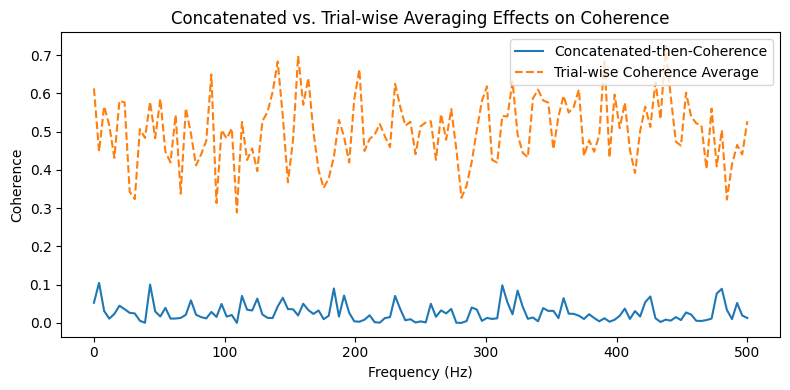

In [3]:
import numpy as np
from scipy.signal import coherence
import matplotlib.pyplot as plt

# Simulation parameters
fs = 1000  # Sampling rate
n_epochs = 10  # Number of trials
epoch_len = 500  # Samples per epoch

# Generate synthetic data: pairs of independent white-noise signals
epochs = [(np.random.randn(epoch_len), np.random.randn(epoch_len)) for _ in range(n_epochs)]

# Method 1: Concatenate across epochs, then compute coherence
x_concat = np.hstack([x for x, _ in epochs])
y_concat = np.hstack([y for _, y in epochs])
f_concat, coh_concat = coherence(x_concat, y_concat, fs=fs, nperseg=256)

# Method 2: Compute coherence per epoch, then average
coh_epochs = [coherence(x, y, fs=fs, nperseg=256)[1] for x, y in epochs]
f_trial, coh_trialwise = f_concat, np.mean(coh_epochs, axis=0)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(f_concat, coh_concat, label='Concatenated-then-Coherence')
plt.plot(f_trial, coh_trialwise, label='Trial-wise Coherence Average', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title('Concatenated vs. Trial-wise Averaging Effects on Coherence')
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
def field_field_coherence(x,y,dt, trl_indx = None):

    if trl_indx is not None:
        x = x[trl_indx,:]
        y = y[trl_indx,:]
#    print(x.shape)
        
    T = x.shape[0]    
    N = x.shape[1] 
    
    #generating arrays
    SYY = np.zeros(int(N/2+1))                            
    SXX = np.zeros(int(N/2+1))                        
    SYX = np.zeros(int(N/2+1), dtype=complex)           

    #loop over trials
    for k in range(T):                                

        yf = rfft((y[k,:]-np.mean(y[k,:])) *hanning(N))   #rfft of y 
        nf = rfft((x[k,:]-np.mean(x[k,:])) *hanning(N))   #rfft of x
        SYY = SYY + ( real( yf*conj(yf) ) )/T       #this appends power spectra (for y) for this trial
        SXX = SXX + ( real( nf*conj(nf) ) )/T           # ""  for x
        SYX = SYX + ( yf*conj(nf)   )/T     # "" xy

    coh = abs(SYX) / np.sqrt(SYY) / np.sqrt(SXX)            
    f = rfftfreq(N, dt)
    
    return coh, f   

def preprocess(data):
    zeros = np.zeros_like(data)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
   
    std[std == 0] = 1  # Avoid division by zero by setting std to 1 where it is 0
    zeros = (data - mean) / std
    return zeros

def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 


In [5]:
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {cl: 
                  {cr: [] for cr in classes_right}
                    for cl in classes_left
                } 

l_al_data = copy.deepcopy(agg_structure)
r_al_data = copy.deepcopy(agg_structure)
a_al_data = copy.deepcopy(agg_structure)

l_ar_data = copy.deepcopy(agg_structure)
r_ar_data = copy.deepcopy(agg_structure)
a_ar_data = copy.deepcopy(agg_structure)


n_values = {cl:
             {cr: {
                'attleft': [],
                'attright': []
                } for cr in classes_right} for cl in classes_left} 

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]

    
    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80
                
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    #preprocess here now that we have traces of all of the relavant trials
    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #so now for each dataset we have a preprocessed set of LFP like signals
    for cl in classes_left:
         for cr in classes_right: 
    
            left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left == cl) & (label_right == cr))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == cl) & (label_right == cr))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]

            n_values[cl][cr][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[cl][cr][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty
          
            if len(left_indices) >= 1: 
                l_al = left_input_SP[left_indices, 100:350]
                r_al = right_input_SP[left_indices, 100:350]
                a_al = attention_SP[left_indices, 100:350] 

                l_al_data[cl][cr].append(l_al)
                r_al_data[cl][cr].append(r_al)
                a_al_data[cl][cr].append(a_al)


            if len(right_indices) >= 1:
                l_ar = left_input_SP[right_indices, 100:350]
                r_ar = right_input_SP[right_indices, 100:350]
                a_ar = attention_SP[right_indices, 100:350]
            
                l_ar_data[cl][cr].append(l_ar)   
                r_ar_data[cl][cr].append(r_ar)
                a_ar_data[cl][cr].append(a_ar)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')


Dataset 1 loaded in 9.46 seconds
Dataset 1 processed in 9.77 seconds
Dataset 2 loaded in 13.59 seconds
Dataset 2 processed in 9.71 seconds
Dataset 4 loaded in 7.64 seconds
Dataset 4 processed in 8.94 seconds
Dataset 8 loaded in 10.18 seconds
Dataset 8 processed in 11.87 seconds
Dataset 14 loaded in 16.12 seconds
Dataset 14 processed in 16.18 seconds
Dataset 15 loaded in 8.05 seconds
Dataset 15 processed in 14.48 seconds
Dataset 20 loaded in 9.66 seconds
Dataset 20 processed in 15.04 seconds
Dataset 23 loaded in 20.69 seconds
Dataset 23 processed in 16.44 seconds
Total load time = 198.06 seconds


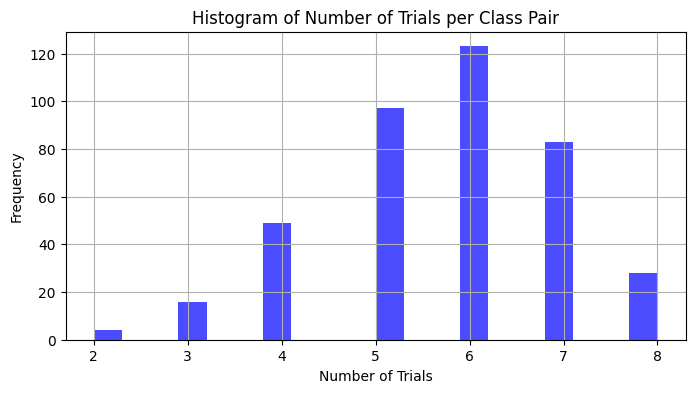

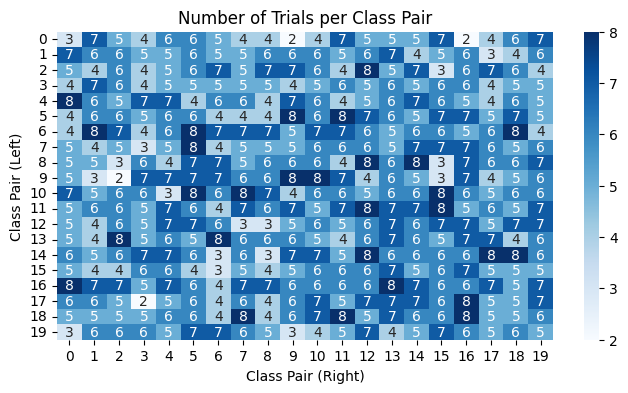

In [6]:
num_classpairs = np.zeros((20, 20))
for i in range(20):
    for j in range(20):
        num_classpairs[i][j] = len(l_al_data[i][j])

#histogram of number of trials per class pair
plt.figure(figsize=(8, 4))  
plt.hist(num_classpairs.flatten(), bins=20, color='blue', alpha=0.7)
plt.xlabel('Number of Trials')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Trials per Class Pair')
plt.grid()
plt.show()


#plot a histogram of these number of each class pairs
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.heatmap(num_classpairs, cmap='Blues', annot=True, fmt='.0f')
plt.xlabel('Class Pair (Right)')
plt.ylabel('Class Pair (Left)')
plt.title('Number of Trials per Class Pair')
plt.show()


See here that there is variation in the number of trials for each class combination. Will look to sample n_min from each class pair and compare the outputs

In [7]:
for cl in classes_left:
    for cr in classes_right:
        if len(l_al_data[cl][cr]) > 0:
            l_al_data[cl][cr] = np.concatenate(l_al_data[cl][cr], axis = 0)
            r_al_data[cl][cr] = np.concatenate(r_al_data[cl][cr], axis = 0)
            a_al_data[cl][cr] = np.concatenate(a_al_data[cl][cr], axis = 0)

            l_ar_data[cl][cr] = np.concatenate(l_ar_data[cl][cr], axis = 0)
            r_ar_data[cl][cr] = np.concatenate(r_ar_data[cl][cr], axis = 0)
            a_ar_data[cl][cr] = np.concatenate(a_ar_data[cl][cr], axis = 0)
            

        else:
            print(f"No data for class left {cl} and class right {cr}.")


#-----------------calculating the number of trials for each class pair----------------
n_values_sum = {cl: {cr: {'attleft': 0, 'attright': 0} for cr in classes_right} for cl in classes_left}


for cl in classes_left:
    for cr in classes_right:
        n_values_sum[cl][cr]['attleft'] = len(l_al_data[cl][cr]) 
        n_values_sum[cl][cr]['attright'] = len(l_ar_data[cl][cr]) 
        

In [8]:
#-------------coherence calculation---------------- this of for all the data available (different numbers of trials)-----------
dt = 0.002
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']   #for coherence I have looked at the mean valuee for these bands
freq_ranges = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  # Actual frequency ranges


lr_split_structure = {cl: {cr: {band:  {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for band in bands} for cr in classes_right} for cl in classes_left} 


coh_means = copy.deepcopy(lr_split_structure)
coh_stdevs = copy.deepcopy(lr_split_structure)

start_time = time.time()
for cl in classes_left:
    coh_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    
        
        #for attention left condition:
        left_in_coh_leftatt, freq = field_field_coherence(
            l_al_data[cl][cr],
            a_al_data[cl][cr],
            dt
        )
        right_in_coh_leftatt, freq = field_field_coherence(
            r_al_data[cl][cr],
            a_al_data[cl][cr],
            dt
        )
        
        #-----taking the mean value of coh for each band  | left condition
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means[cl][cr][band]['left_attleft'].append(
                np.mean(left_in_coh_leftatt[band_idx]))  #taking the mean across trials
            coh_means[cl][cr][band]['right_attleft'].append(
                np.mean(right_in_coh_leftatt[band_idx]))

            coh_stdevs[cl][cr][band]['left_attleft'].append(
                np.std(left_in_coh_leftatt[band_idx], ddof=1))
            coh_stdevs[cl][cr][band]['right_attleft'].append(
                np.std(right_in_coh_leftatt[band_idx], ddof=1))
            


for cl in classes_left:
    for cr in classes_right: 
        if n_values_sum[cl][cr]['attright'] == 0:  #right class pairs that have trials
            print(f"[SKIP] {cl}-{cr}: no attleft trials")
            continue        

        #for attention right condition:
        left_in_coh_rightatt, freq = field_field_coherence(
            l_ar_data[cl][cr],
            a_ar_data[cl][cr],
            dt
        )
        right_in_coh_rightatt, freq = field_field_coherence(
            r_ar_data[cl][cr],
            a_ar_data[cl][cr],
            dt
        )   

        if left_in_coh_leftatt.size == 0 or right_in_coh_leftatt.size == 0:
            print(f"[WARN] empty coherence array for {cl}-{cr} under attleft")


        #taking the mean value of coh for each band  | right condition
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means[cl][cr][band]['left_attright'].append(
                np.mean(left_in_coh_rightatt[band_idx]))  #taking the mean across trials
            coh_means[cl][cr][band]['right_attright'].append(
                np.mean(right_in_coh_rightatt[band_idx]))

            coh_stdevs[cl][cr][band]['left_attright'].append(
                np.std(left_in_coh_rightatt[band_idx], ddof=1))
            coh_stdevs[cl][cr][band]['right_attright'].append(
                np.std(right_in_coh_rightatt[band_idx], ddof=1))




    print(f"Class pair {cl} {cr} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - start_time
print(f"Total run time: {run_time:.2f} seconds")


c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Class pair 0 19 processed in 0.15 seconds
Class pair 1 19 processed in 0.25 seconds
Class pair 2 19 processed in 0.36 seconds
Class pair 3 19 processed in 0.46 seconds
Class pair 4 19 processed in 0.59 seconds
Class pair 5 19 processed in 0.70 seconds
Class pair 6 19 processed in 0.77 seconds
Class pair 7 19 processed in 0.89 seconds
Class pair 8 19 processed in 0.99 seconds
Class pair 9 19 processed in 1.08 seconds
Class pair 10 19 processed in 1.21 seconds
Class pair 11 19 processed in 1.31 seconds
Class pair 12 19 processed in 1.41 seconds
Class pair 13 19 processed in 1.51 seconds
Class pair 14 19 processed in 1.59 seconds
Class pair 15 19 processed in 1.67 seconds
Class pair 16 19 processed in 1.77 seconds
Class pair 17 19 processed in 1.84 seconds
Class pair 18 19 processed in 1.92 seconds
Class pair 19 19 processed in 1.99 seconds
Total run time: 4.48 seconds


In [9]:
#-------------coherence calculation---------------- this takes 2 trials of each class pair ---------------
dt = 0.002
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']   #for coherence I have looked at the mean valuee for these bands
freq_ranges = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  # Actual frequency ranges


lr_split_structure = {cl: {cr: {band:  {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for band in bands} for cr in classes_right} for cl in classes_left} 


coh_means2 = copy.deepcopy(lr_split_structure)
coh_stdevs2 = copy.deepcopy(lr_split_structure)

start_time = time.time()
for cl in classes_left:
    coh_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    
        
        #for attention left condition:
        left_in_coh_leftatt, freq = field_field_coherence(
            l_al_data[cl][cr][0:2],
            a_al_data[cl][cr][0:2],
            dt
        )
        right_in_coh_leftatt, freq = field_field_coherence(
            r_al_data[cl][cr][0:2],
            a_al_data[cl][cr][0:2],
            dt
        )
        
        #-----taking the mean value of coh for each band  | left condition
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means2[cl][cr][band]['left_attleft'].append(
                np.mean(left_in_coh_leftatt[band_idx]))  #taking the mean across trials
            coh_means2[cl][cr][band]['right_attleft'].append(
                np.mean(right_in_coh_leftatt[band_idx]))

            coh_stdevs2[cl][cr][band]['left_attleft'].append(
                np.std(left_in_coh_leftatt[band_idx], ddof=1))
            coh_stdevs2[cl][cr][band]['right_attleft'].append(
                np.std(right_in_coh_leftatt[band_idx], ddof=1))
            


for cl in classes_left:
    for cr in classes_right: 
        if n_values_sum[cl][cr]['attright'] == 0:  #right class pairs that have trials
            print(f"[SKIP] {cl}-{cr}: no attleft trials")
            continue        

        #for attention right condition:
        left_in_coh_rightatt, freq = field_field_coherence(
            l_ar_data[cl][cr][0:2],
            a_ar_data[cl][cr][0:2],
            dt
        )
        right_in_coh_rightatt, freq = field_field_coherence(
            r_ar_data[cl][cr][0:2],
            a_ar_data[cl][cr][0:2],
            dt
        )   

        if left_in_coh_leftatt.size == 0 or right_in_coh_leftatt.size == 0:
            print(f"[WARN] empty coherence array for {cl}-{cr} under attleft")


        #taking the mean value of coh for each band  | right condition
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means2[cl][cr][band]['left_attright'].append(
                np.mean(left_in_coh_rightatt[band_idx]))  #taking the mean across trials
            coh_means2[cl][cr][band]['right_attright'].append(
                np.mean(right_in_coh_rightatt[band_idx]))

            coh_stdevs2[cl][cr][band]['left_attright'].append(
                np.std(left_in_coh_rightatt[band_idx], ddof=1))
            coh_stdevs2[cl][cr][band]['right_attright'].append(
                np.std(right_in_coh_rightatt[band_idx], ddof=1))




    print(f"Class pair {cl} {cr} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - start_time
print(f"Total run time: {run_time:.2f} seconds")


Class pair 0 19 processed in 0.05 seconds
Class pair 1 19 processed in 0.07 seconds
Class pair 2 19 processed in 0.09 seconds
Class pair 3 19 processed in 0.11 seconds
Class pair 4 19 processed in 0.14 seconds
Class pair 5 19 processed in 0.16 seconds
Class pair 6 19 processed in 0.18 seconds
Class pair 7 19 processed in 0.21 seconds
Class pair 8 19 processed in 0.23 seconds
Class pair 9 19 processed in 0.25 seconds
Class pair 10 19 processed in 0.28 seconds
Class pair 11 19 processed in 0.30 seconds
Class pair 12 19 processed in 0.32 seconds
Class pair 13 19 processed in 0.35 seconds
Class pair 14 19 processed in 0.37 seconds
Class pair 15 19 processed in 0.40 seconds
Class pair 16 19 processed in 0.42 seconds
Class pair 17 19 processed in 0.44 seconds
Class pair 18 19 processed in 0.46 seconds
Class pair 19 19 processed in 0.49 seconds
Total run time: 0.92 seconds


In [10]:
#looking for 0's in the data
for cl in classes_left:
    for cr in classes_right:
        for band in bands:
            for att in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                if len(coh_means[cl][cr][band][att]) == 0:
                    print(f"Empty data for {cl}-{cr} under {band} and {att}")
            

In [11]:
#--------plotting the results------------- both dfferent numbers of trials, and 2 trials of each class pair ---------------
results_to_plot =copy.deepcopy(lr_split_structure) 

for band in bands:
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[cl][cr][band][key] = coh_means[cl][cr][band][key]

results_to_plot2 =copy.deepcopy(lr_split_structure)

for band in bands:
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot2[cl][cr][band][key] = coh_means2[cl][cr][band][key]
                


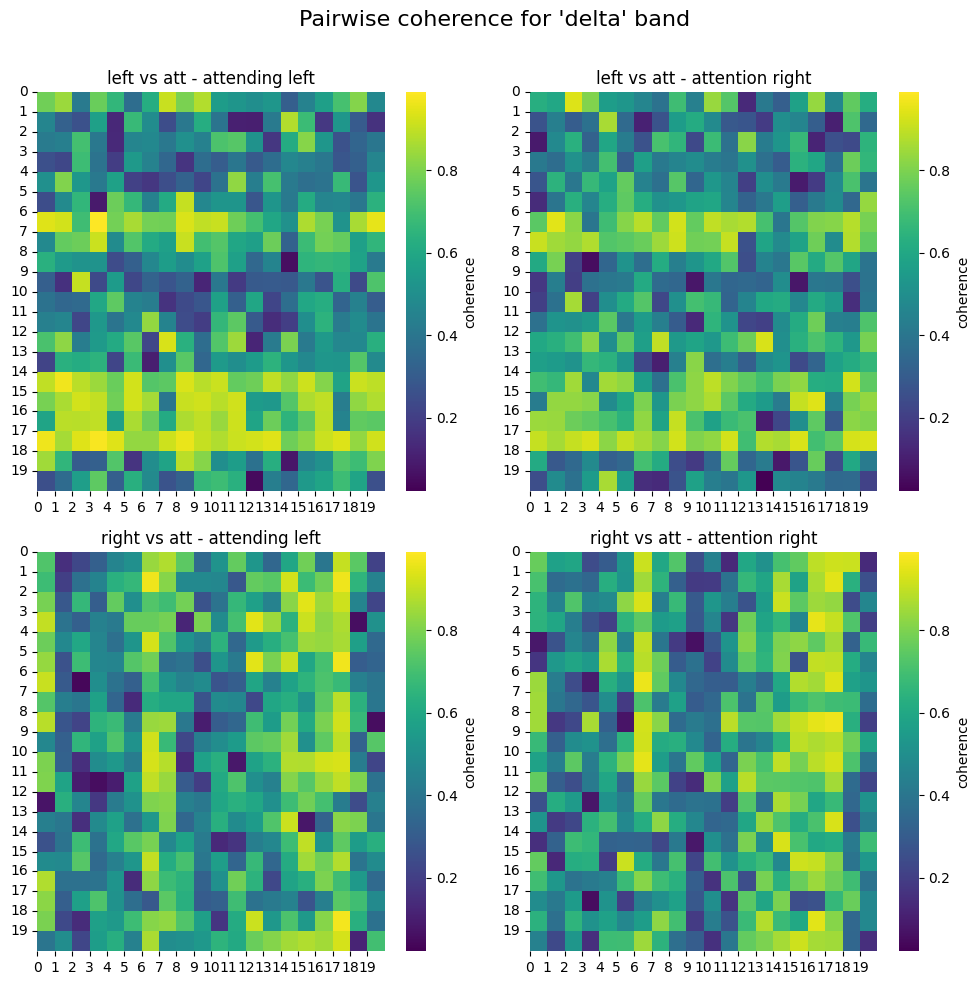

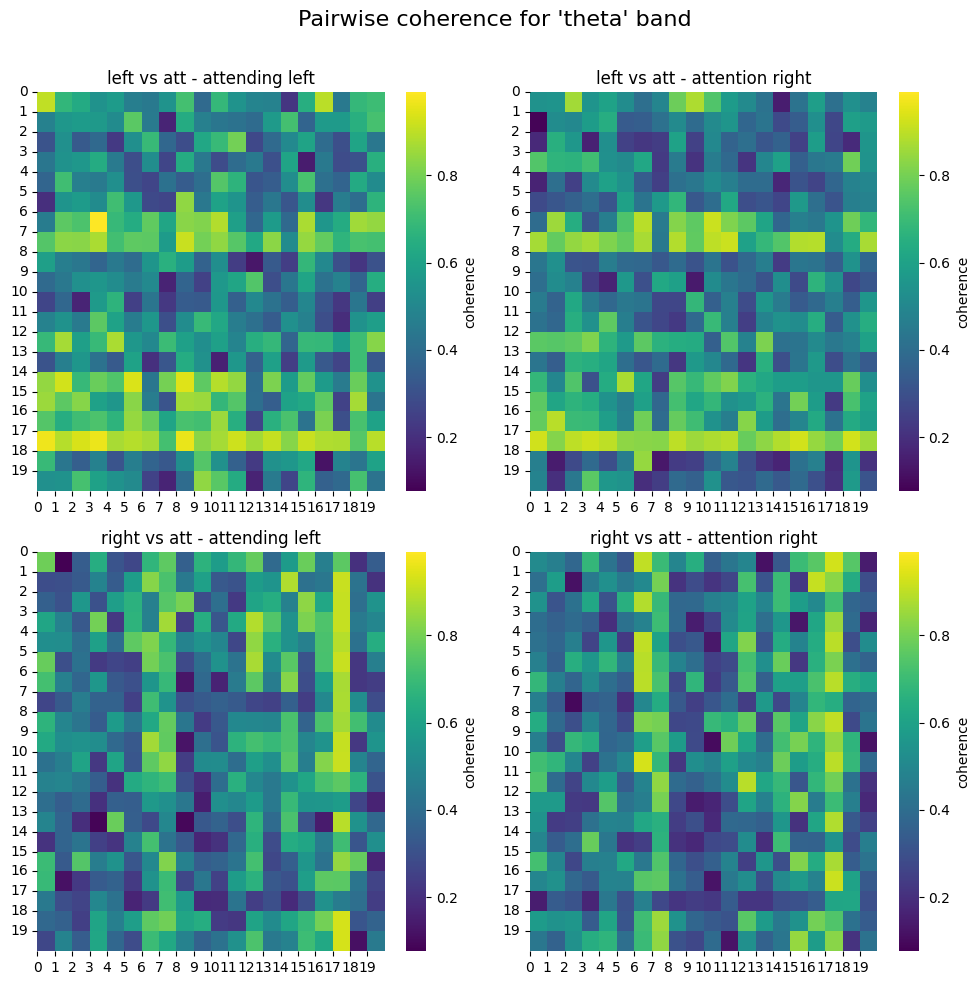

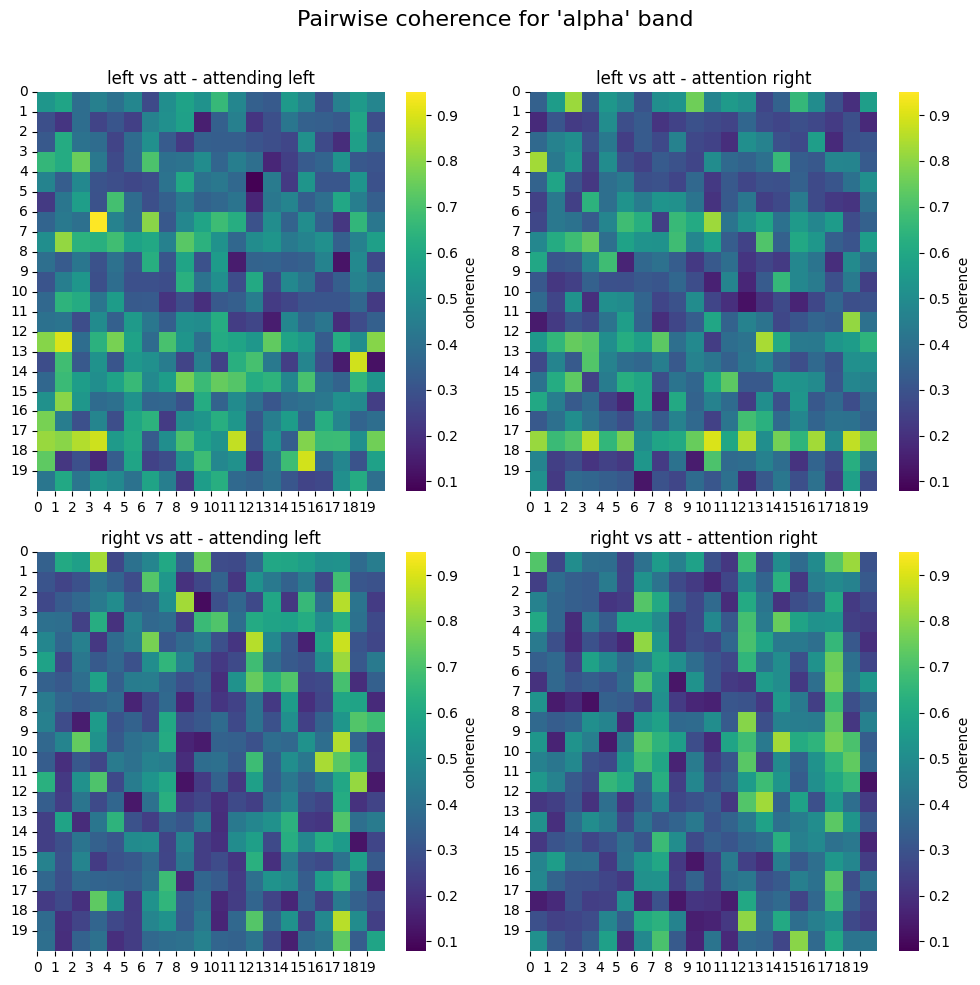

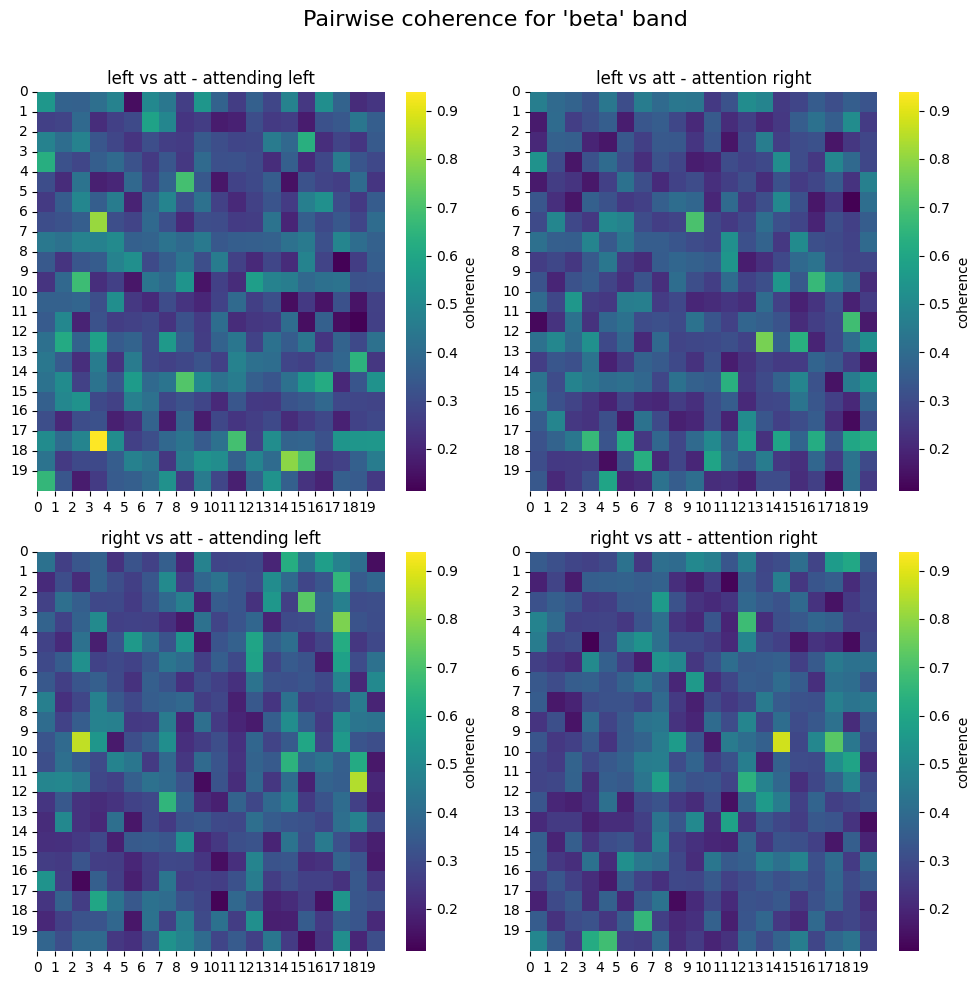

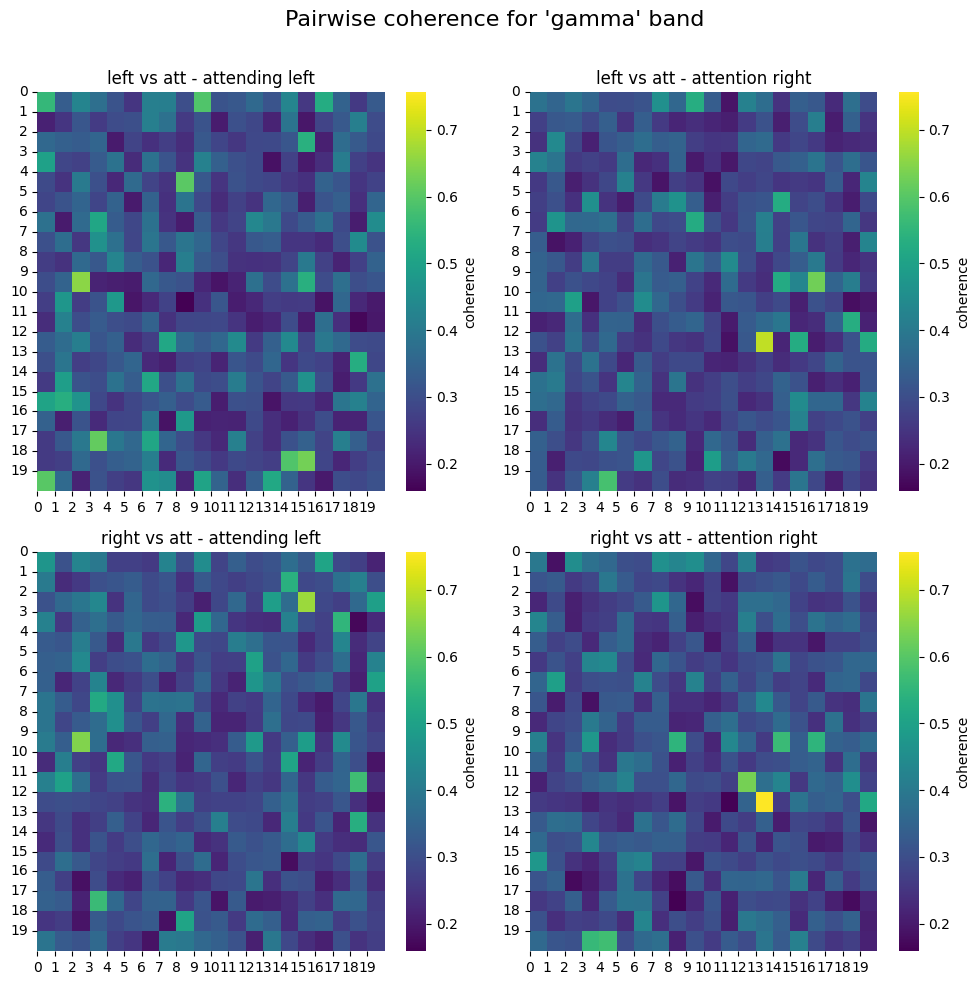

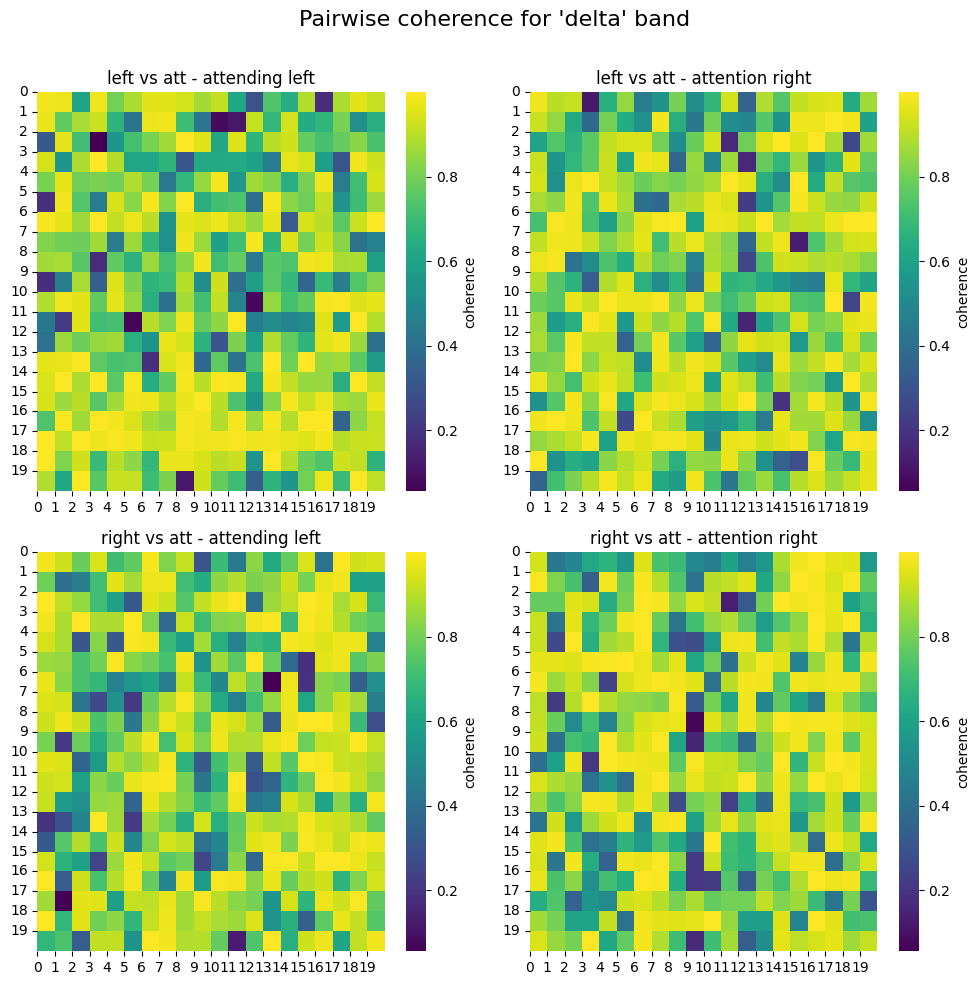

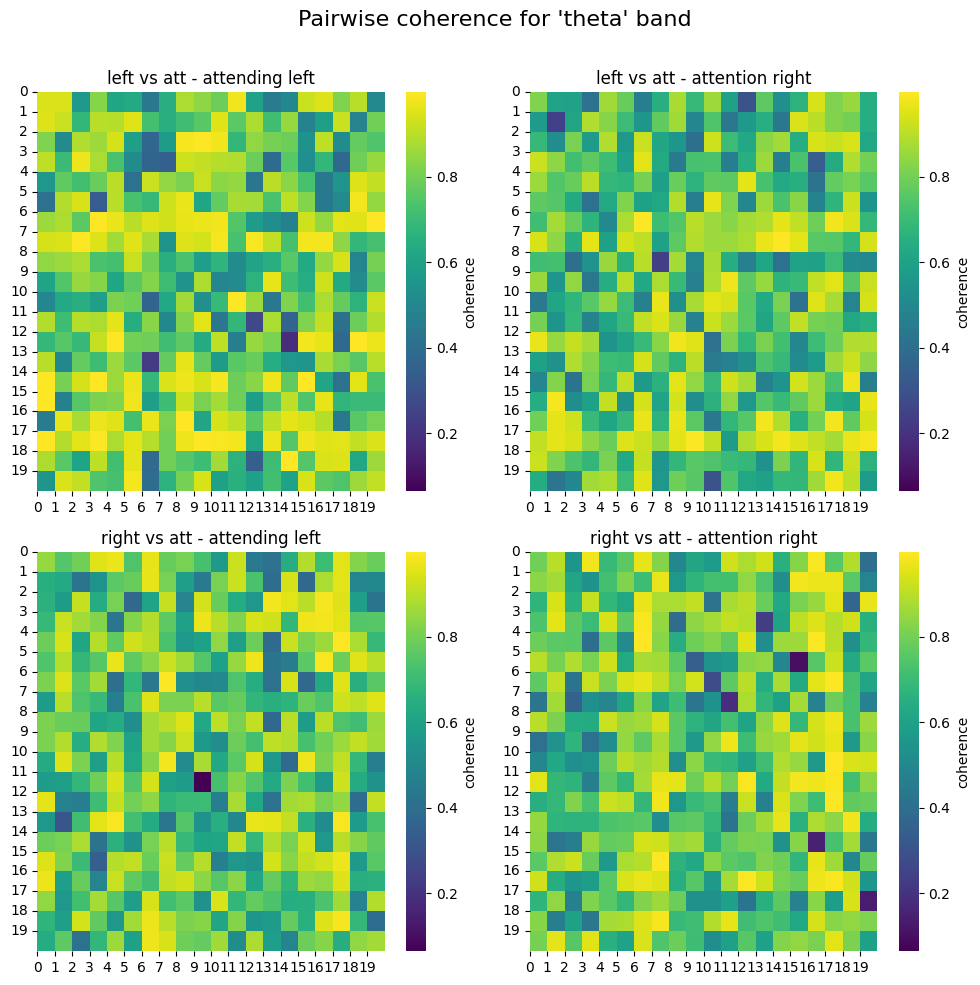

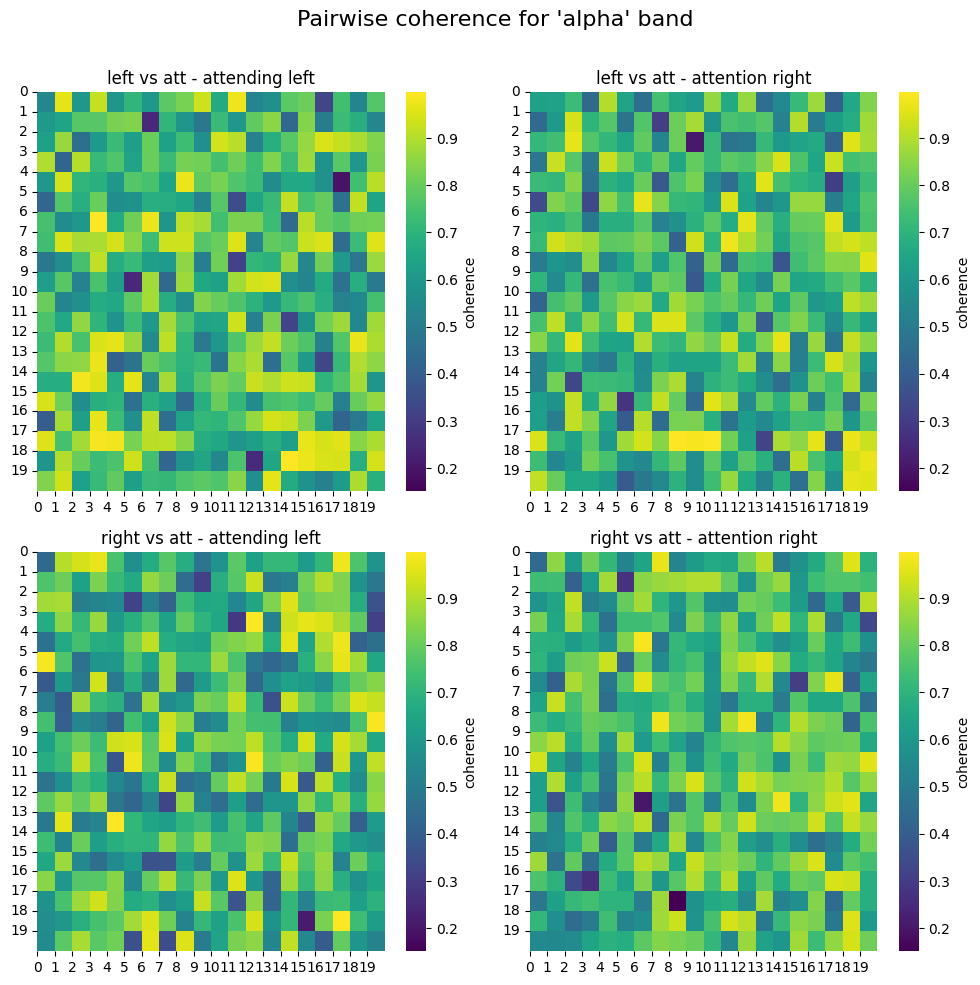

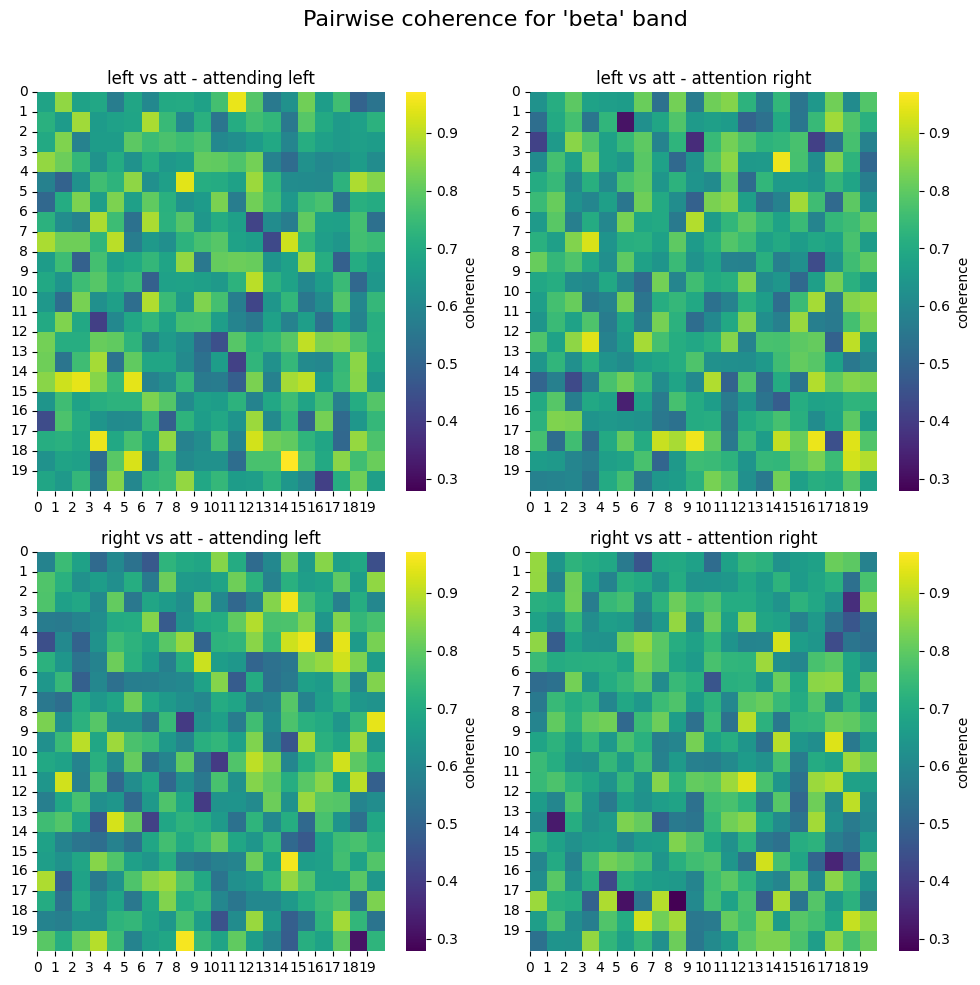

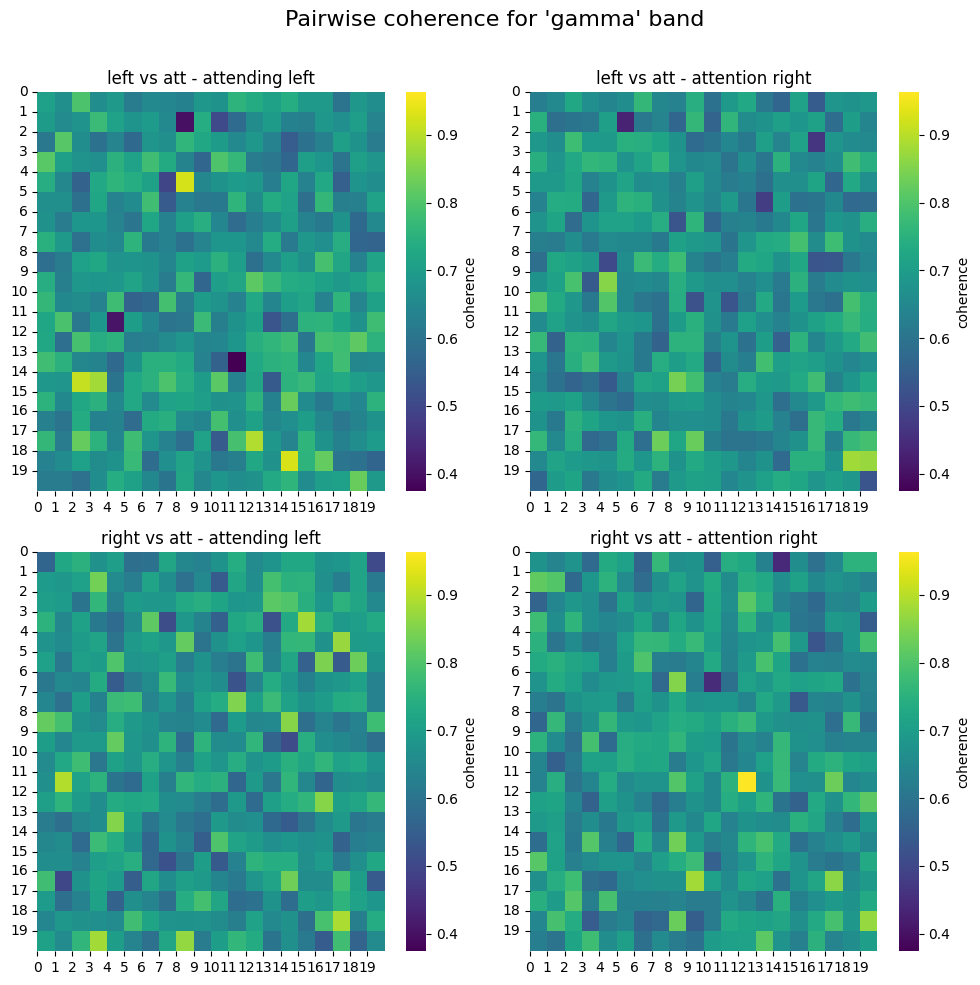

In [12]:
def calculate_vmin_vmax_scalar(data, classes_left, classes_right, band):
    vals = []
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                lst = data[cl][cr][band][key]
                if lst:                   # skip empty lists
                    vals.append(lst[0])    # or take np.mean(lst) if you prefer
    if not vals:
        raise ValueError(f"No non-empty entries for band {band}")
    return min(vals), max(vals)

# recompute your vmin/vmax correctly:
vmin_delta, vmax_delta = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'delta')
vmin_theta, vmax_theta = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'theta')
vmin_alpha, vmax_alpha = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'alpha')
vmin_beta, vmax_beta = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'beta')
vmin_gamma, vmax_gamma = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'gamma')
# … same for the others …

vmin_delta2, vmax_delta2 = calculate_vmin_vmax_scalar(results_to_plot2, classes_left, classes_right, 'delta')
vmin_theta2, vmax_theta2 = calculate_vmin_vmax_scalar(results_to_plot2, classes_left, classes_right, 'theta')
vmin_alpha2, vmax_alpha2 = calculate_vmin_vmax_scalar(results_to_plot2, classes_left, classes_right, 'alpha')
vmin_beta2, vmax_beta2 = calculate_vmin_vmax_scalar(results_to_plot2, classes_left, classes_right, 'beta')
vmin_gamma2, vmax_gamma2 = calculate_vmin_vmax_scalar(results_to_plot2, classes_left, classes_right, 'gamma')

def plot_4_heat(data, band, vmin, vmax):
    nL, nR = len(classes_left), len(classes_right)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    def mkmat(key):
        mat = np.full((nL, nR), np.nan)
        for i, cl in enumerate(classes_left):
            for j, cr in enumerate(classes_right):
                lst = data[cl][cr][band][key]
                if lst:
                    mat[i,j] = lst[0]
        return mat

    sns.heatmap(mkmat('left_attleft'), ax=ax[0,0], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[0,0].set_title(f'left vs att ‑ attending left')
    ax[0,0].set_xticks(np.arange(nR)); ax[0,0].set_yticks(np.arange(nL))
    ax[0,0].set_xticklabels(classes_right); ax[0,0].set_yticklabels(classes_left)

    sns.heatmap(mkmat('right_attleft'), ax=ax[1,0], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[1,0].set_title(f'right vs att ‑ attending left')
    ax[1,0].set_xticks(np.arange(nR)); ax[1,0].set_yticks(np.arange(nL))
    ax[1,0].set_xticklabels(classes_right); ax[1,0].set_yticklabels(classes_left)

    sns.heatmap(mkmat('left_attright'), ax=ax[0,1], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[0,1].set_title(f'left vs att ‑ attention right')
    ax[0,1].set_xticks(np.arange(nR)); ax[0,1].set_yticks(np.arange(nL))
    ax[0,1].set_xticklabels(classes_right); ax[0,1].set_yticklabels(classes_left)

    sns.heatmap(mkmat('right_attright'), ax=ax[1,1], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[1,1].set_title(f'right vs att ‑ attention right')
    ax[1,1].set_xticks(np.arange(nR)); ax[1,1].set_yticks(np.arange(nL))
    ax[1,1].set_xticklabels(classes_right); ax[1,1].set_yticklabels(classes_left)

    fig.suptitle(f"Pairwise coherence for '{band}' band", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


plot_4_heat(results_to_plot, 'delta', vmin_delta, vmax_delta)
plot_4_heat(results_to_plot, 'theta', vmin_theta, vmax_theta)
plot_4_heat(results_to_plot, 'alpha', vmin_alpha, vmax_alpha)
plot_4_heat(results_to_plot, 'beta', vmin_beta, vmax_beta)
plot_4_heat(results_to_plot, 'gamma', vmin_gamma, vmax_gamma)

plot_4_heat(results_to_plot2, 'delta', vmin_delta2, vmax_delta2)
plot_4_heat(results_to_plot2, 'theta', vmin_theta2, vmax_theta2)
plot_4_heat(results_to_plot2, 'alpha', vmin_alpha2, vmax_alpha2)
plot_4_heat(results_to_plot2, 'beta', vmin_beta2, vmax_beta2)
plot_4_heat(results_to_plot2, 'gamma', vmin_gamma2, vmax_gamma2)

In [13]:
for cl in classes_left:
    for cr in classes_right:
        for band in bands:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[cl][cr][band][key] = coh_means[cl][cr][band][key]


lowest_classes = lowest_classes = [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7))]

results_to_plot_low = copy.deepcopy(lr_split_structure)


for cl in classes_left:
    for cr in classes_right:
        if (cl, cr) in lowest_classes:
            for band in bands:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[cl][cr][band][key] = coh_means[cl][cr][band][key]
        else:   #if not in lowest classes, set to -
            for band in bands:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[cl][cr][band][key] = -1

print(np.array(results_to_plot))
print(np.array(results_to_plot_low))

hist_values_all = [results_to_plot[cl][cr][band]['left_attleft']
                    for cl in classes_left for cr in classes_right]
print(hist_values_all)
print(np.array(hist_values_all[0]).shape)
                


{np.int64(0): {np.int64(0): {'delta': {'left_attleft': [np.float64(0.7794755885644937)], 'right_attleft': [np.float64(0.7246920863916613)], 'left_attright': [np.float64(0.6295155612067381)], 'right_attright': [np.float64(0.7639130931995128)]}, 'theta': {'left_attleft': [np.float64(0.9018621216267039)], 'right_attleft': [np.float64(0.7891345113484729)], 'left_attright': [np.float64(0.5427701650405915)], 'right_attright': [np.float64(0.5106333152879616)]}, 'alpha': {'left_attleft': [np.float64(0.5356055864610059)], 'right_attleft': [np.float64(0.3456194573873262)], 'left_attright': [np.float64(0.34478117317635953)], 'right_attright': [np.float64(0.7125610923224809)]}, 'beta': {'left_attleft': [np.float64(0.549498540279844)], 'right_attleft': [np.float64(0.4189944780799778)], 'left_attright': [np.float64(0.4617715191623304)], 'right_attright': [np.float64(0.3477574189649469)]}, 'gamma': {'left_attleft': [np.float64(0.5560175368661548)], 'right_attleft': [np.float64(0.4702378998809922)], '

Want here to plot some scatter plots for each band, where each point is the coh mean for the given class comvination - this should give 400 points per plot. 

have plotted coherence with left/out and right/out for attention left and attention conditions
significant would be thaht for attention left, left/out would be greater than right/out therefore blue sitting below the diagonal. then orange sitting above the axis.  

delta  → t =  1.339, p = 0.181


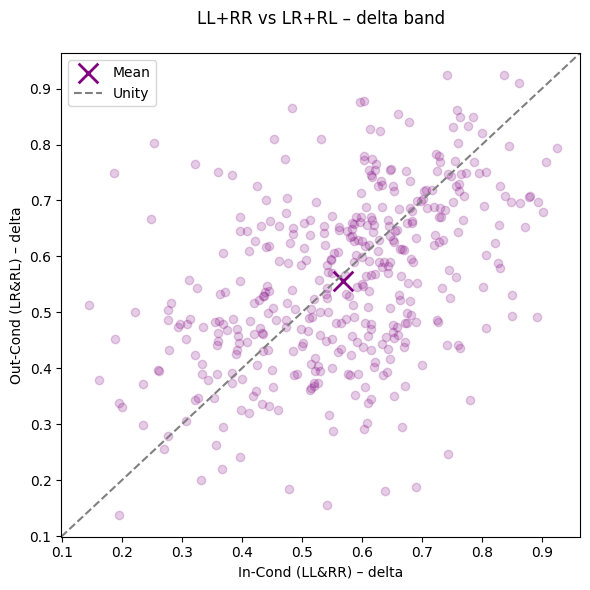

theta  → t =  3.535, p = 0.000455


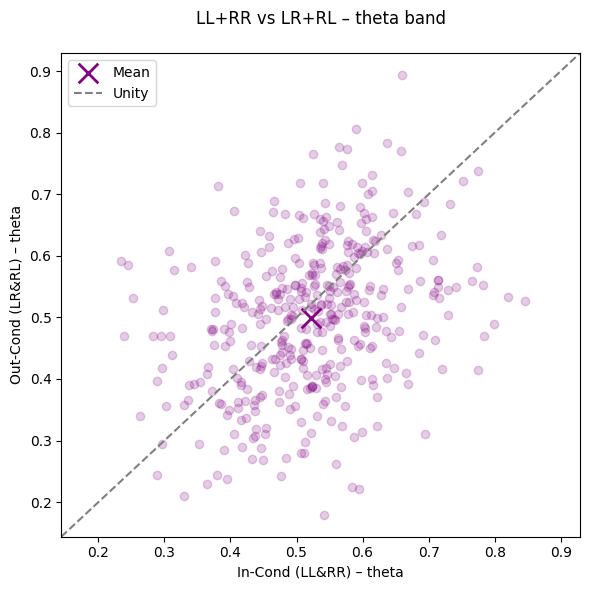

alpha  → t =  2.582, p = 0.0102


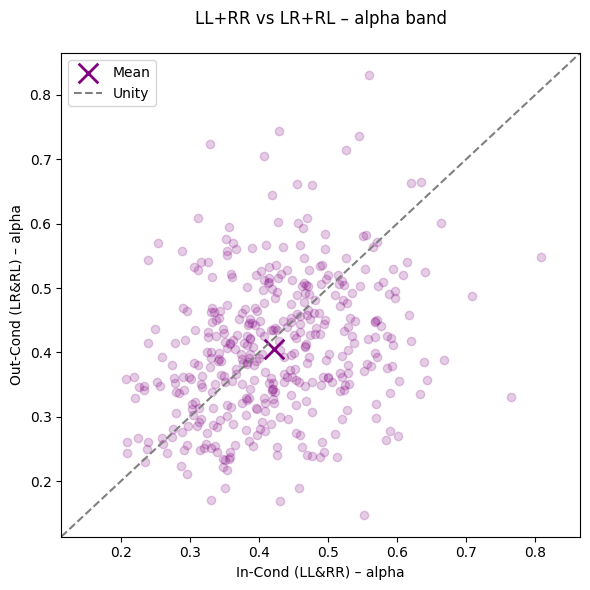

beta   → t =  2.792, p = 0.00549


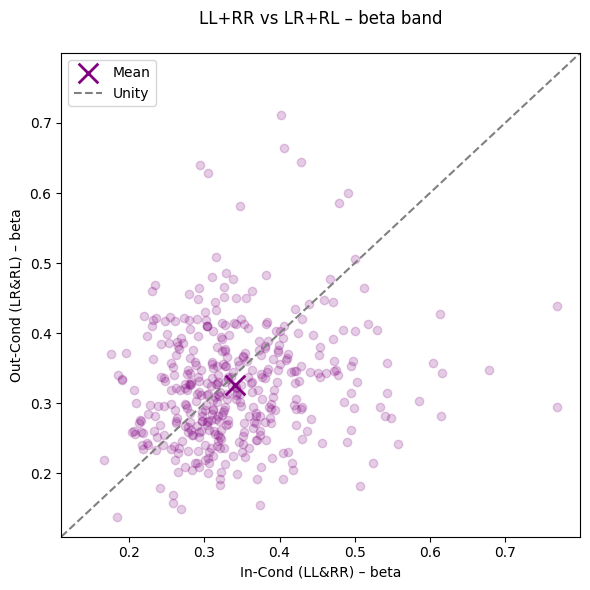

gamma  → t =  1.666, p = 0.0965


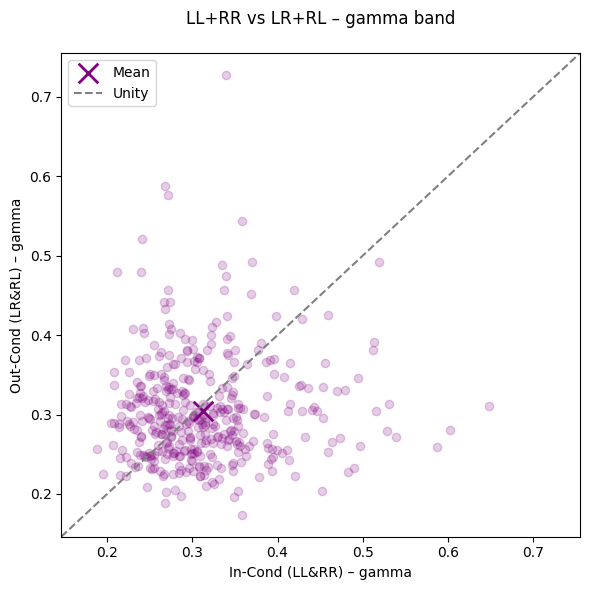

In [20]:
from scipy.stats import ttest_rel

for band in bands:
    in_vals = []
    out_vals = []

    # build in‑ and out‑ condition arrays
    for cl in classes_left:
        for cr in classes_right:
            la = coh_means[cl][cr][band]['left_attleft']
            ra = coh_means[cl][cr][band]['right_attleft']
            lr = coh_means[cl][cr][band]['left_attright']
            rr = coh_means[cl][cr][band]['right_attright']

            if la and ra and lr and rr:
                ll_val = la[0]
                rr_val = ra[0]
                lr_val = lr[0]
                rl_val = rr[0]

                in_vals .append((ll_val + rr_val) / 2)
                out_vals.append((lr_val + rl_val) / 2)

    # paired t‑test
    t_stat, p_val = ttest_rel(in_vals, out_vals, nan_policy='omit')
    print(f"{band:6s} → t = {t_stat:6.3f}, p = {p_val:.3}")

    # now your scatter plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(in_vals, out_vals, alpha=0.2, color='purple')
    ax.scatter(np.mean(in_vals), np.mean(out_vals), color='purple', marker='x', s=200, linewidth = 2, label='Mean')
    # unity line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, '--', color='gray', label='Unity')
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel(f'In‑Cond (LL&RR) – {band}')
    ax.set_ylabel(f'Out‑Cond (LR&RL) – {band}')
    ax.set_title(f'LL+RR vs LR+RL – {band} band\n')
               #  f"paired t = {t_stat:.2f}, p = {p_val:.3f}")
    ax.legend()
    plt.tight_layout()
    plt.show()


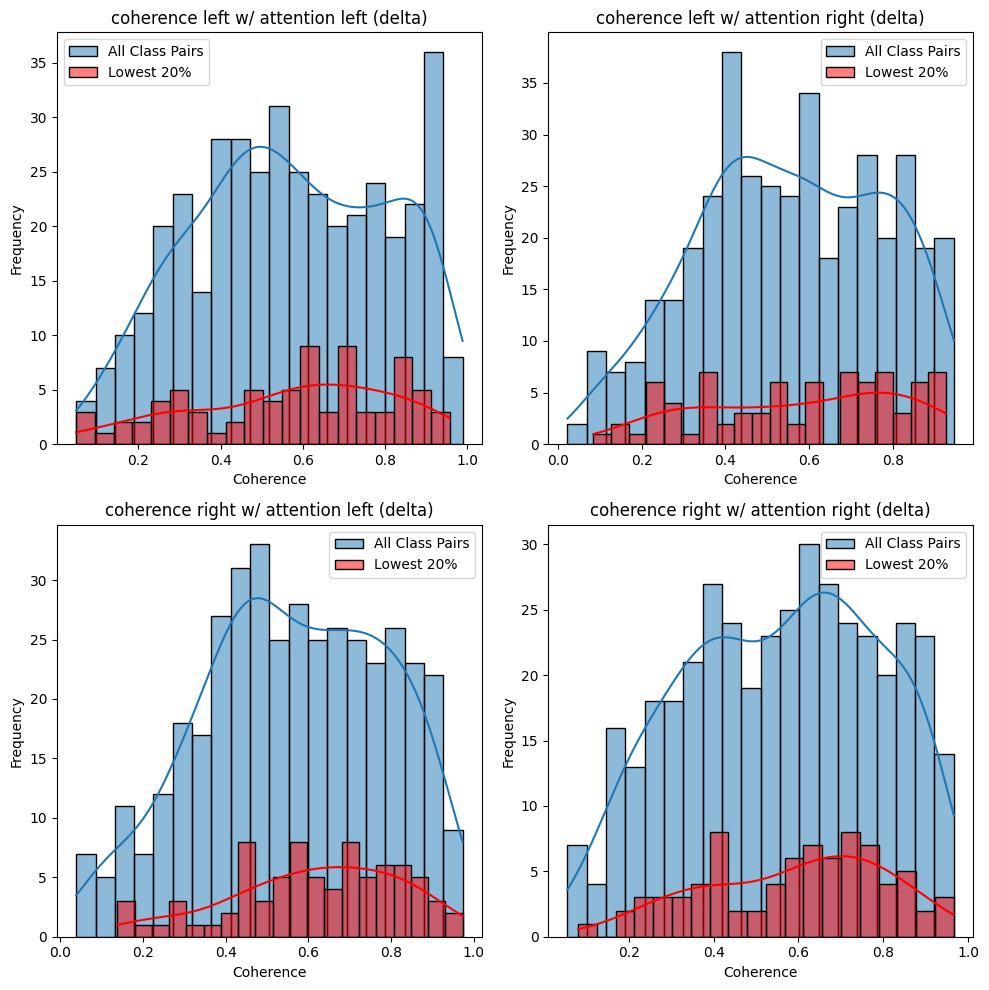

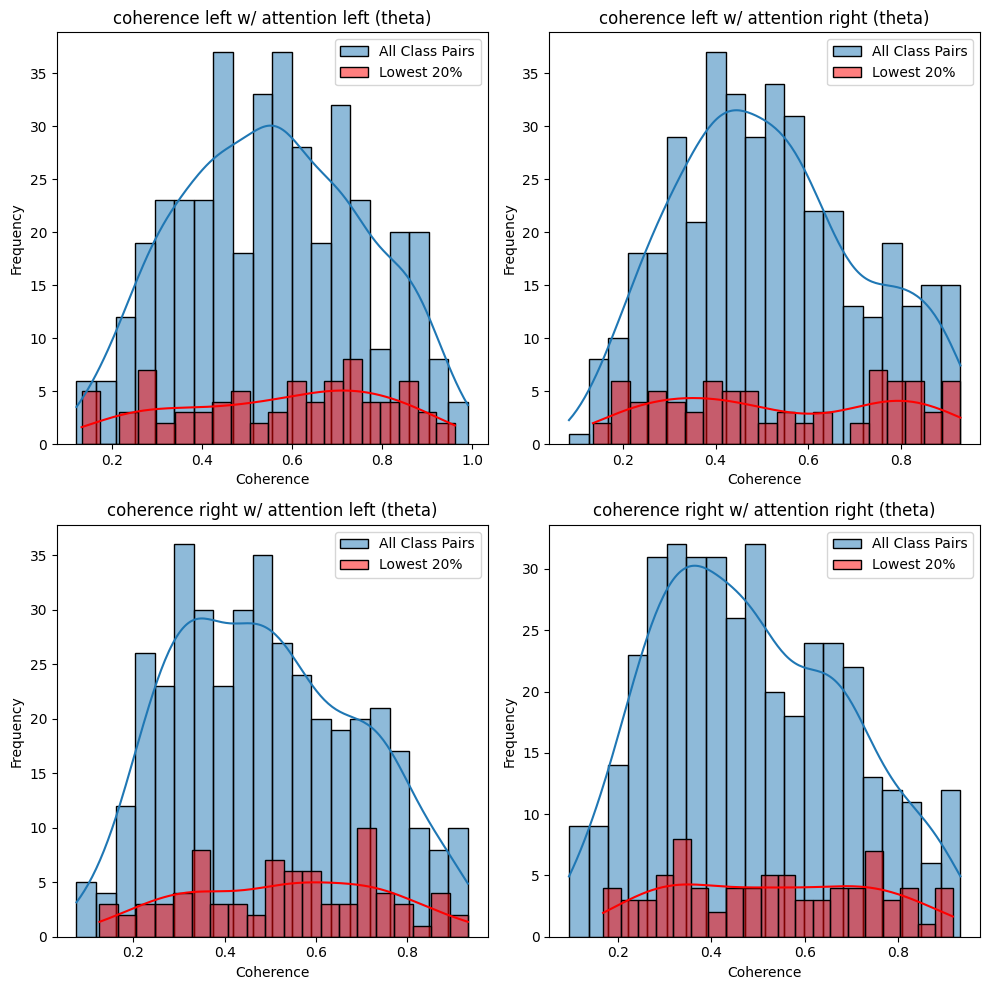

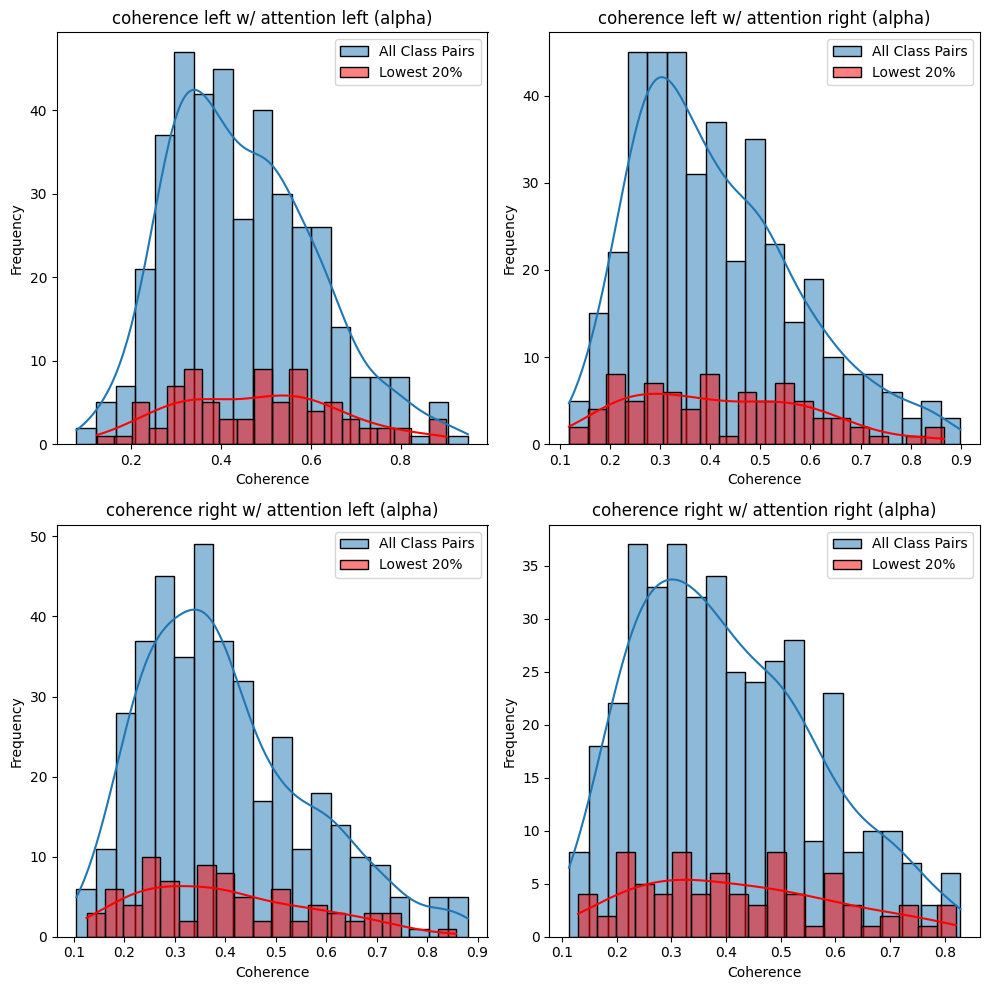

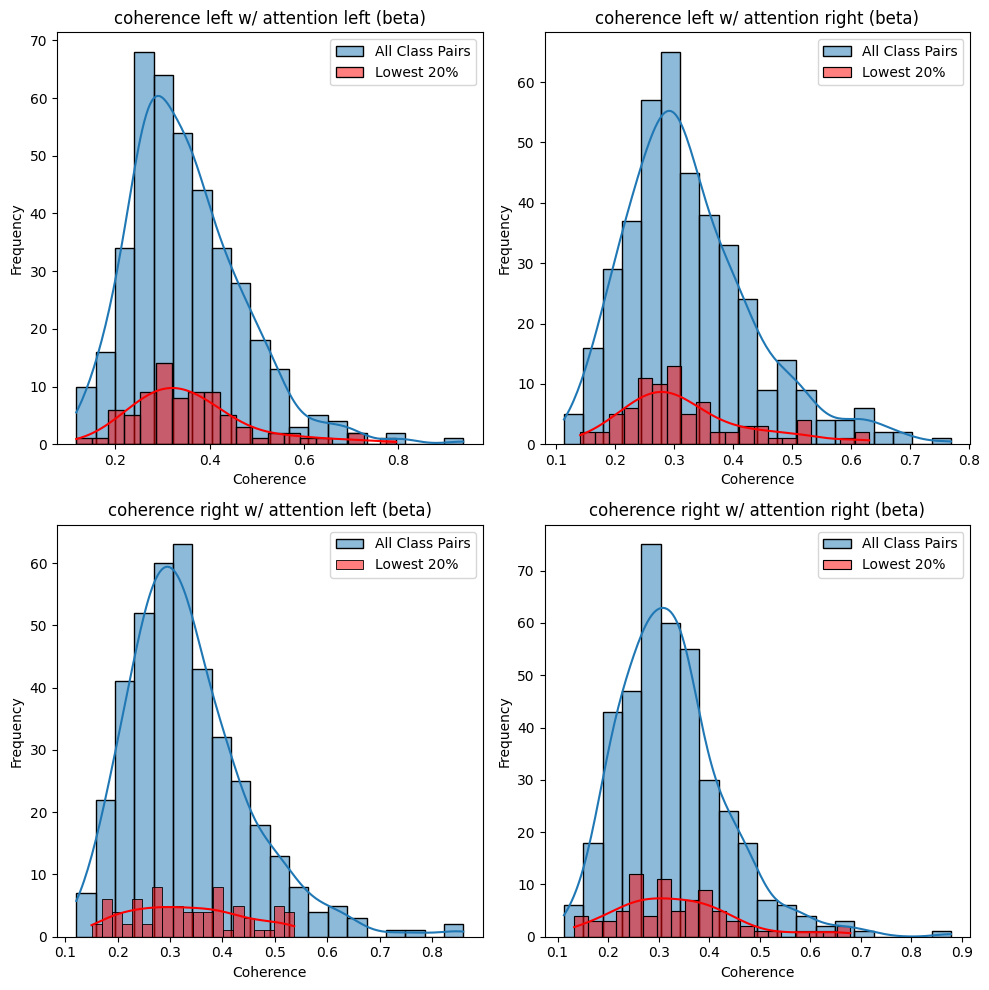

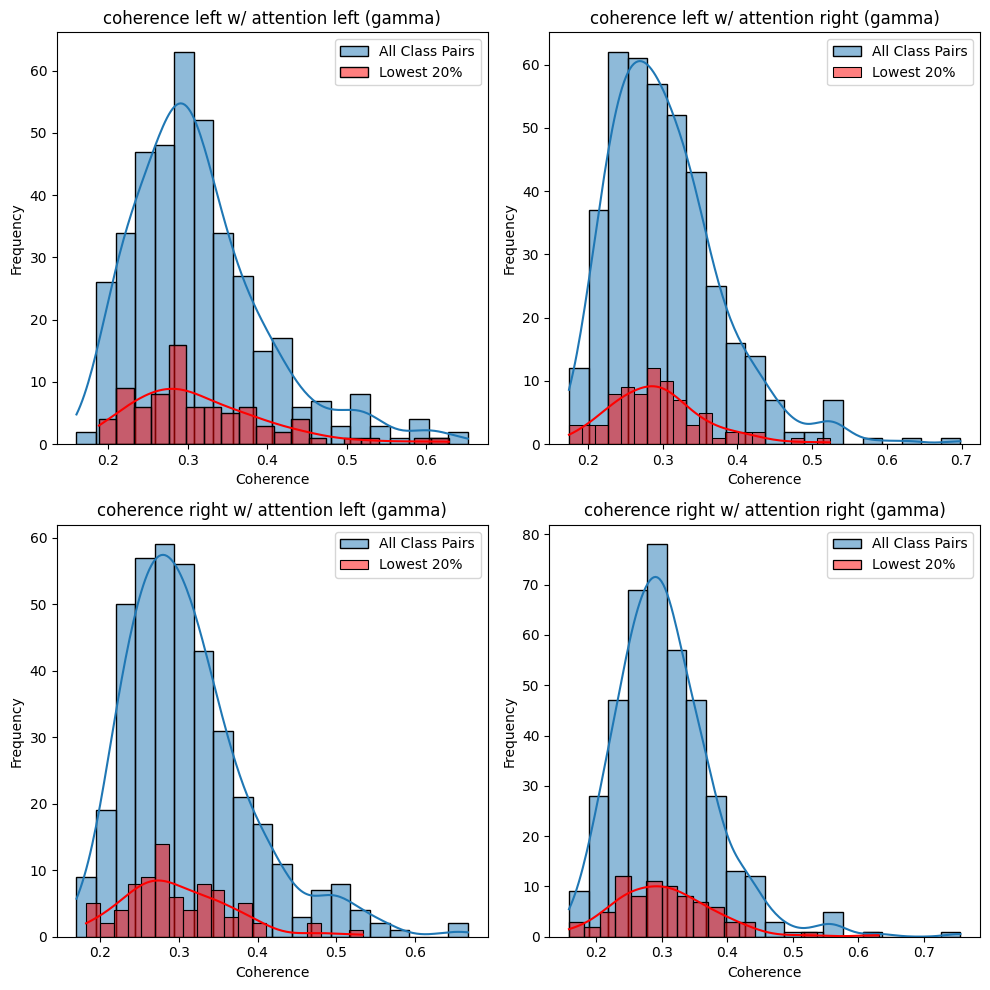

In [16]:
def plot_histograms(data, datalow, band):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    # Flatten the extracted wSMI values into 1D lists before plotting
    hist_values_all = [data[cl][cr][band]['left_attleft']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['left_attleft']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['left_attleft'] != -1]
    sns.histplot(np.array(hist_values_all), ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[0, 0], bins=20, kde=True, label="Lowest 20%", palette = ["red"], alpha=0.5)
    ax[0,0].set_title(f'coherence left w/ attention left ({band})')
    ax[0,0].set_xlabel('Coherence')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].legend()

    # Repeat for the other plots
    hist_values_all = [data[cl][cr][band]['right_attleft']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['right_attleft']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['right_attleft'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[1, 0], bins=20, kde=True, label="Lowest 20%", palette = ["red"], alpha=0.5)
    ax[1,0].set_title(f'coherence right w/ attention left ({band})')
    ax[1,0].set_xlabel('Coherence')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].legend()

    hist_values_all = [data[cl][cr][band]['left_attright']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['left_attright']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['left_attright'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[0, 1], bins=20, kde=True, label="Lowest 20%", palette = ["red"], alpha=0.5)
    ax[0,1].set_title(f'coherence left w/ attention right ({band})')
    ax[0,1].set_xlabel('Coherence')
    ax[0,1].set_ylabel('Frequency')
    ax[0,1].legend()

    hist_values_all = [data[cl][cr][band]['right_attright']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['right_attright']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['right_attright'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[1, 1], bins=20, kde=True, label="Lowest 20%", palette = ["red"], alpha=0.5)
    ax[1,1].set_title(f'coherence right w/ attention right ({band})')
    ax[1,1].set_xlabel('Coherence')
    ax[1,1].set_ylabel('Frequency')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

plot_histograms(results_to_plot, results_to_plot_low, 'delta')
plot_histograms(results_to_plot, results_to_plot_low, 'theta')
plot_histograms(results_to_plot, results_to_plot_low, 'alpha')
plot_histograms(results_to_plot, results_to_plot_low, 'beta')
plot_histograms(results_to_plot, results_to_plot_low, 'gamma')
